In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import fft
from scipy import stats
from scipy.signal import get_window
import glob
import time
def rffts(ys): #the imput are 2d arrays bc this function computes multiple ffts
    Ys = fft.rfft(ys, axis = 1) 
    all_phases = np.angle(Ys)
    
    return Ys, all_phases


def filtering_func(freqs, fft, phases, f1, f2):
    fft_in_range = fft[(freqs >= f1) & (freqs <= f2)]

    peak = np.max(fft_in_range)

    peak_indices = np.where(fft_in_range == peak)[0]
    peak_f = freqs[(freqs >= f1) & (freqs <= f2)][peak_indices]

    peak_phase = phases[(freqs >= f1) & (freqs <= f2)][peak_indices]

    print(f'sum: {np.sum(np.isin(freqs, peak_f))}')
    return peak_f, peak_phase

In [103]:
hour = '15.42'
day = '08082024'

In [104]:
file_pattern = f"../../Waveforms/{day}/{day}_{hour}/{day}_{hour}_wf.csv/{day}_{hour}_wf_*.csv"
file_list = glob.glob(file_pattern)

amplitudes_list = []


if not file_list:
    print("No files found for the given pattern.")
else:
    for i, file in enumerate(file_list):
        df = pd.read_csv(file)
        if i == 0:
            print(df.iloc[:, 0])
            print(df.iloc[:, 1])
            times = pd.to_numeric(df.iloc[1:, 0], errors = 'coerce').values
        amplitudes = pd.to_numeric(df.iloc[1:, 1], errors='coerce').values
        amplitudes_list.append(amplitudes)
        
all_amplitudes = np.stack(amplitudes_list, axis = 0)
N = len(times)
print(f"len(times): {N}")
print(f"{times}")

0               (us)
1         0.00000000
2         0.00080000
3         0.00160000
4         0.00240000
            ...     
62500    49.99920067
62501    50.00000067
62502    50.00080067
62503    50.00160067
62504    50.00240067
Name: Time, Length: 62505, dtype: object
0               (mV)
1        -1.96850400
2        -1.57480300
3        -1.18110200
4        -0.78740150
            ...     
62500     0.00000000
62501     0.39370070
62502    -0.39370070
62503    -1.18110200
62504    -1.18110200
Name: Channel D, Length: 62505, dtype: object
len(times): 62504
[0.00000000e+00 8.00000000e-04 1.60000000e-03 ... 5.00008007e+01
 5.00016007e+01 5.00024007e+01]


## FFT

In [105]:
span = times[-1]
print(f"span: {span}") 
f_s = len(times) / span
print(f"f_s = {f_s}")
freqs = fft.rfftfreq(len(times), 1/f_s) #window lenght, sample spacing
print(freqs[-1]) ##this should be the half of f_s.
print(f"len(freqs): {len(freqs)}")

span: 50.00240067
f_s = 1250.0199822905822
625.0099911452911
len(freqs): 31253


In [106]:
f_s_new = 10 * freqs[-1]
print(f"ridefinition of f_s: {f_s_new}")

ridefinition of f_s: 6250.099911452911


In [107]:
Ys, all_phases = rffts(all_amplitudes)
Ys = np.abs(Ys)
avg_fft = np.mean(Ys, axis = 0) 
n = np.max(avg_fft)
avg_fft_au = avg_fft / n

avg_phases = np.mean(all_phases, axis = 0)

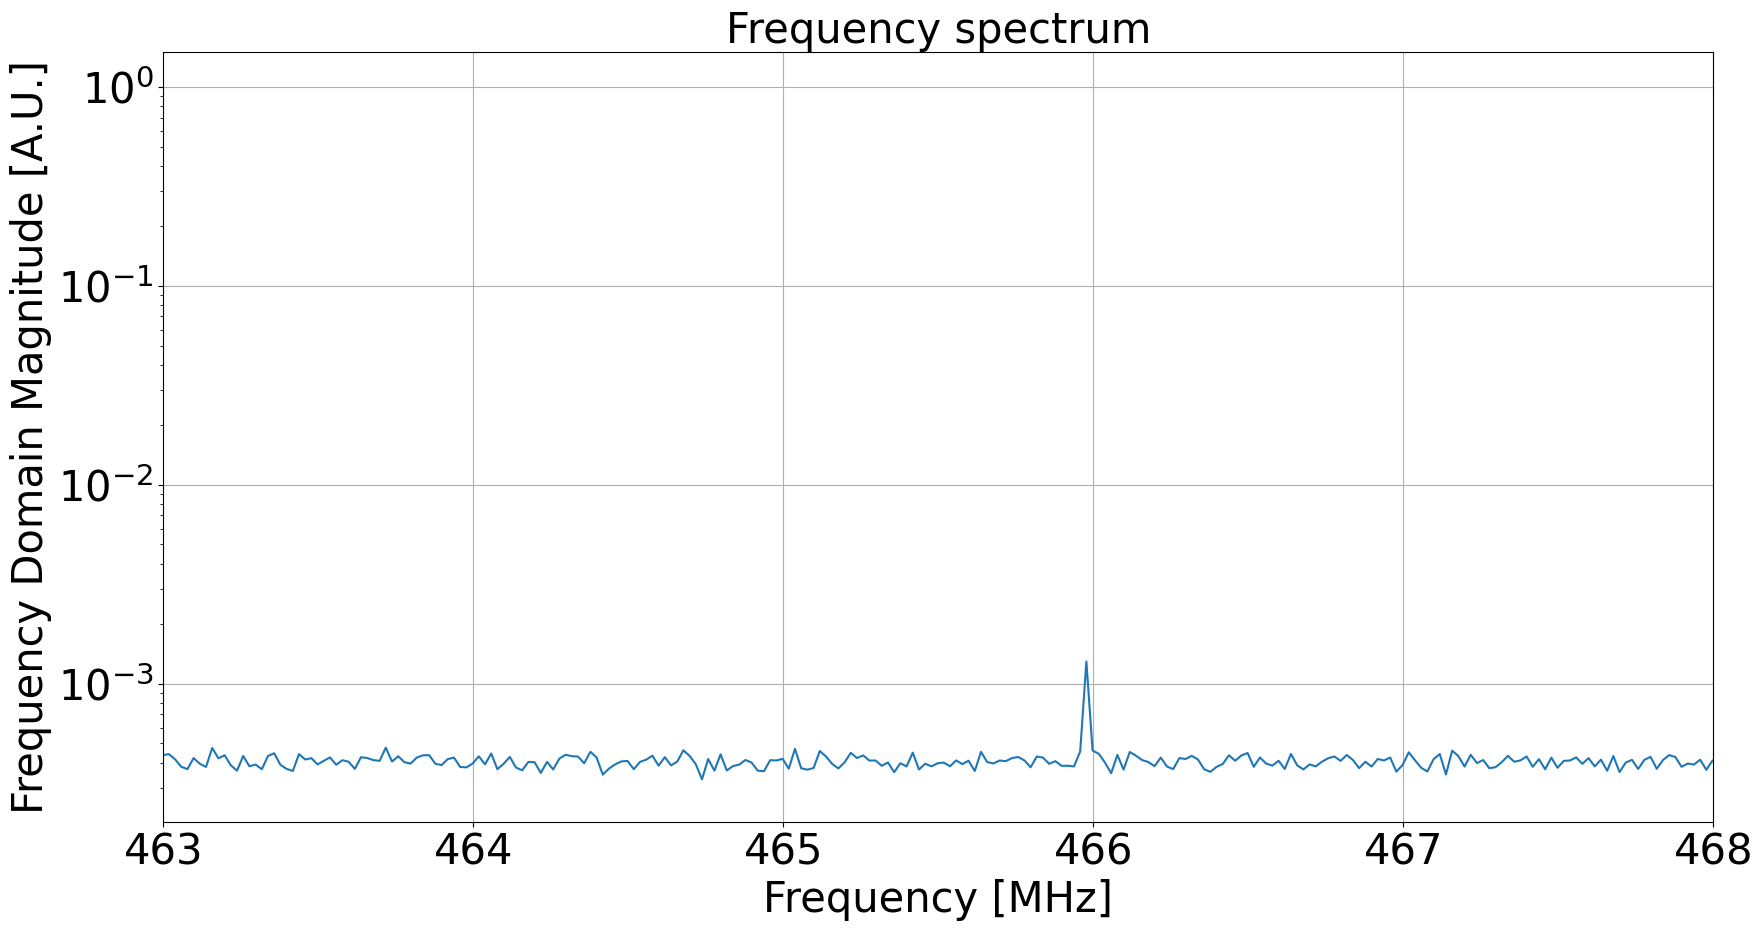

In [108]:
f1 = 463
f2 = 468

plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(freqs, avg_fft_au)

plt.axvline(468.75749336, color = 'red', alpha = 0.2)
plt.title('Frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Frequency Domain Magnitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.semilogy()
plt.grid(True)
plt.xlim(f1, f2)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

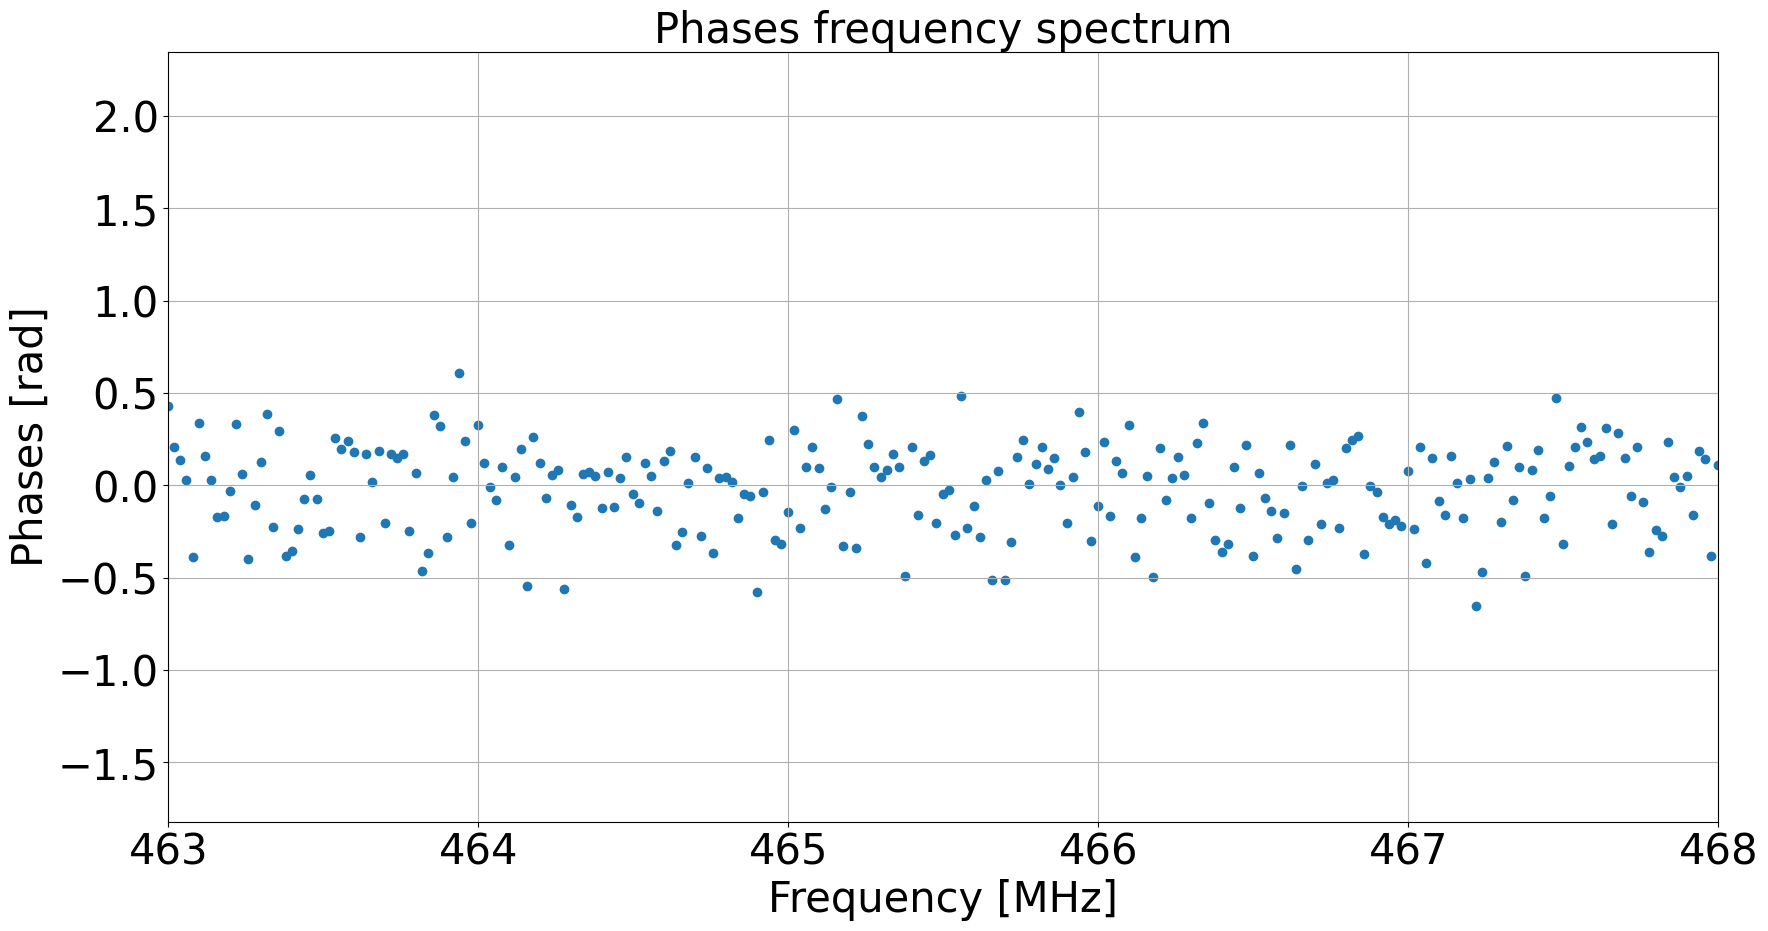

In [109]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.scatter(freqs, avg_phases)

plt.axvline(468.75749336, color = 'red', alpha = 0.2)
plt.title('Phases frequency spectrum', fontsize = 30)
plt.xlabel('Frequency [MHz]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Phases [rad]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(f1, f2)
#plt.semilogx()

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## Filtering

In [110]:
peak_f, peak_phases = filtering_func(freqs, avg_fft_au, avg_phases, f1, f2)
print(f"peak_phases: {peak_phases}")
print(f"peak_f: {peak_f}")

print(f"len_times: {len(times)}")

times_new = np.arange(0, times[-1], 1 / f_s_new)
print(f"len(times_new): {len(times_new)}")
print(f"times_new: {times_new}")

times_new_2 = np.arange(N) / f_s_new
print(f"len(times_new_2): {len(times_new_2)}")
print(f"times_new_2: {times_new_2}")

print(f"f_s: {f_s}")

noise_wf = np.sin(peak_f* 2*np.pi * times_new_2 + peak_phases)

sum: 1
peak_phases: [-0.29933826]
peak_f: [465.97762683]
len_times: 62504
len(times_new): 312520
times_new: [0.00000000e+00 1.59997442e-04 3.19994885e-04 ... 5.00019207e+01
 5.00020807e+01 5.00022407e+01]
len(times_new_2): 62504
times_new_2: [0.00000000e+00 1.59997442e-04 3.19994885e-04 ... 1.00000001e+01
 1.00001601e+01 1.00003201e+01]
f_s: 1250.0199822905822


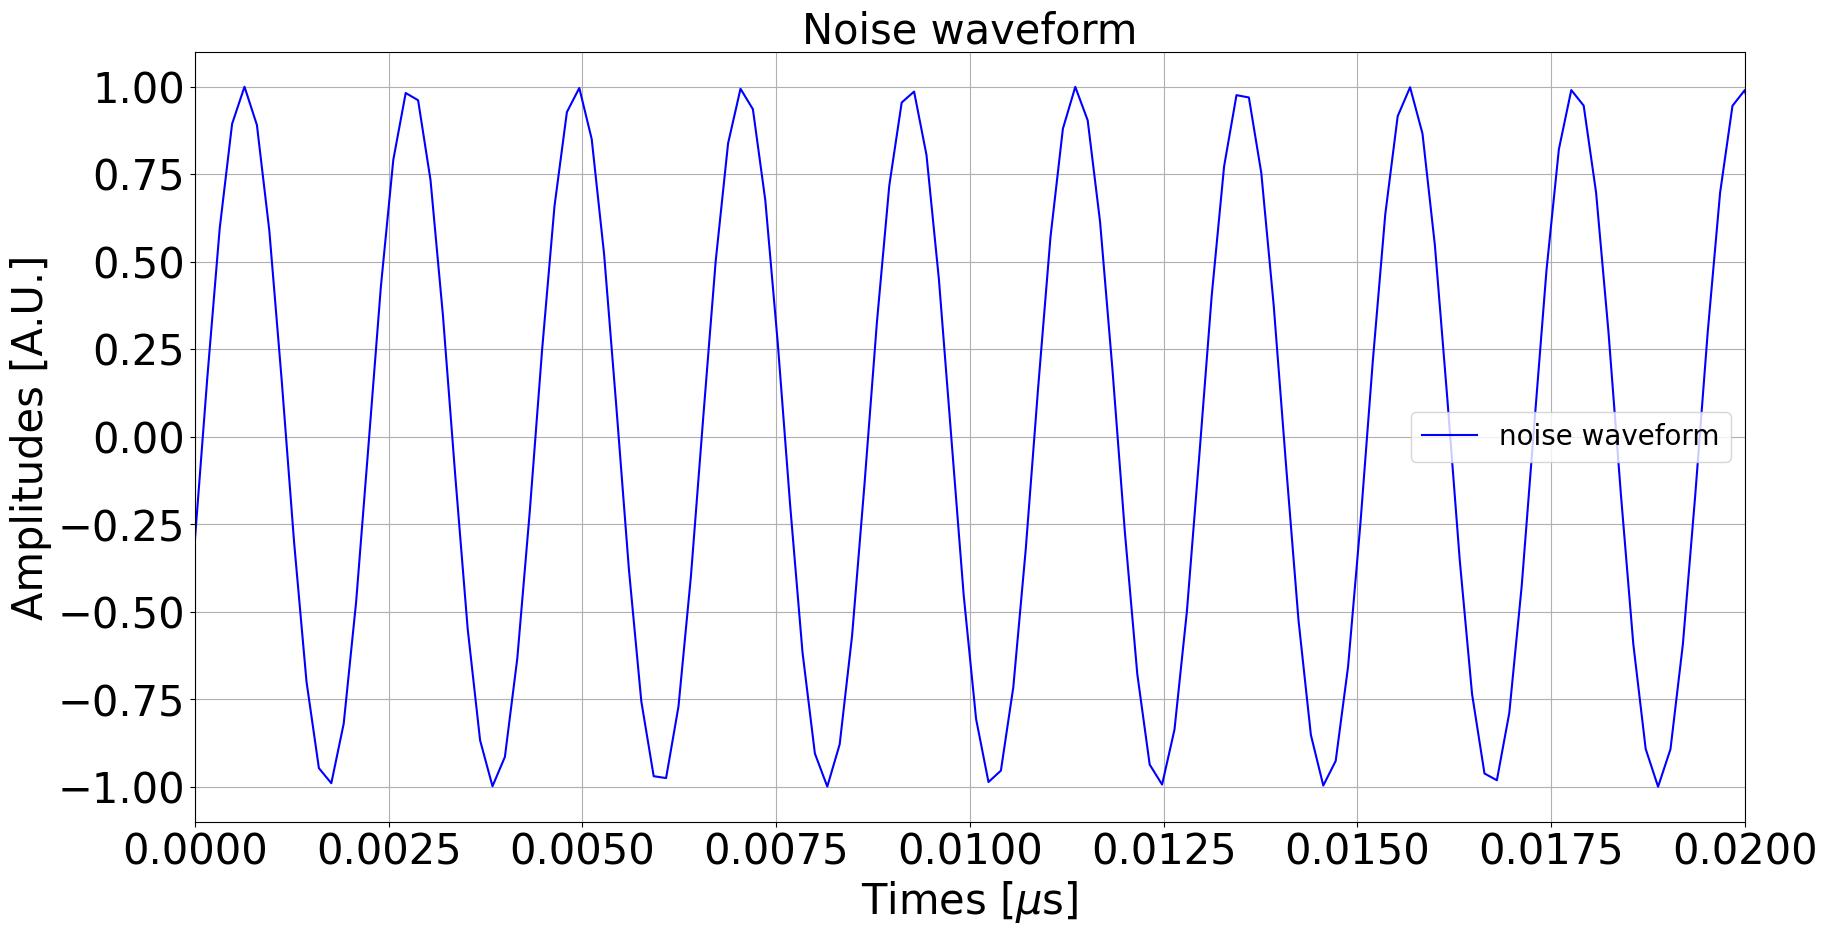

In [116]:
plt.figure(figsize=(20, 10))
#plt.errorbar(freqs, avg_fft_au, yerr = stds_fft, fmt='o', markersize = 2, ecolor='red', capsize = 3, capthick=1, elinewidth=1)
plt.plot(times_new_2, noise_wf, color = 'blue', label = 'noise waveform')

plt.title('Noise waveform', fontsize = 30)
plt.xlabel(r'Times [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitudes [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 0.02)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("250724_17.23/fft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

## Compare to average waveform

In [112]:
print(len(avg_fft_au))
original_wf = fft.irfft(avg_fft_au)

31253


62504
62504


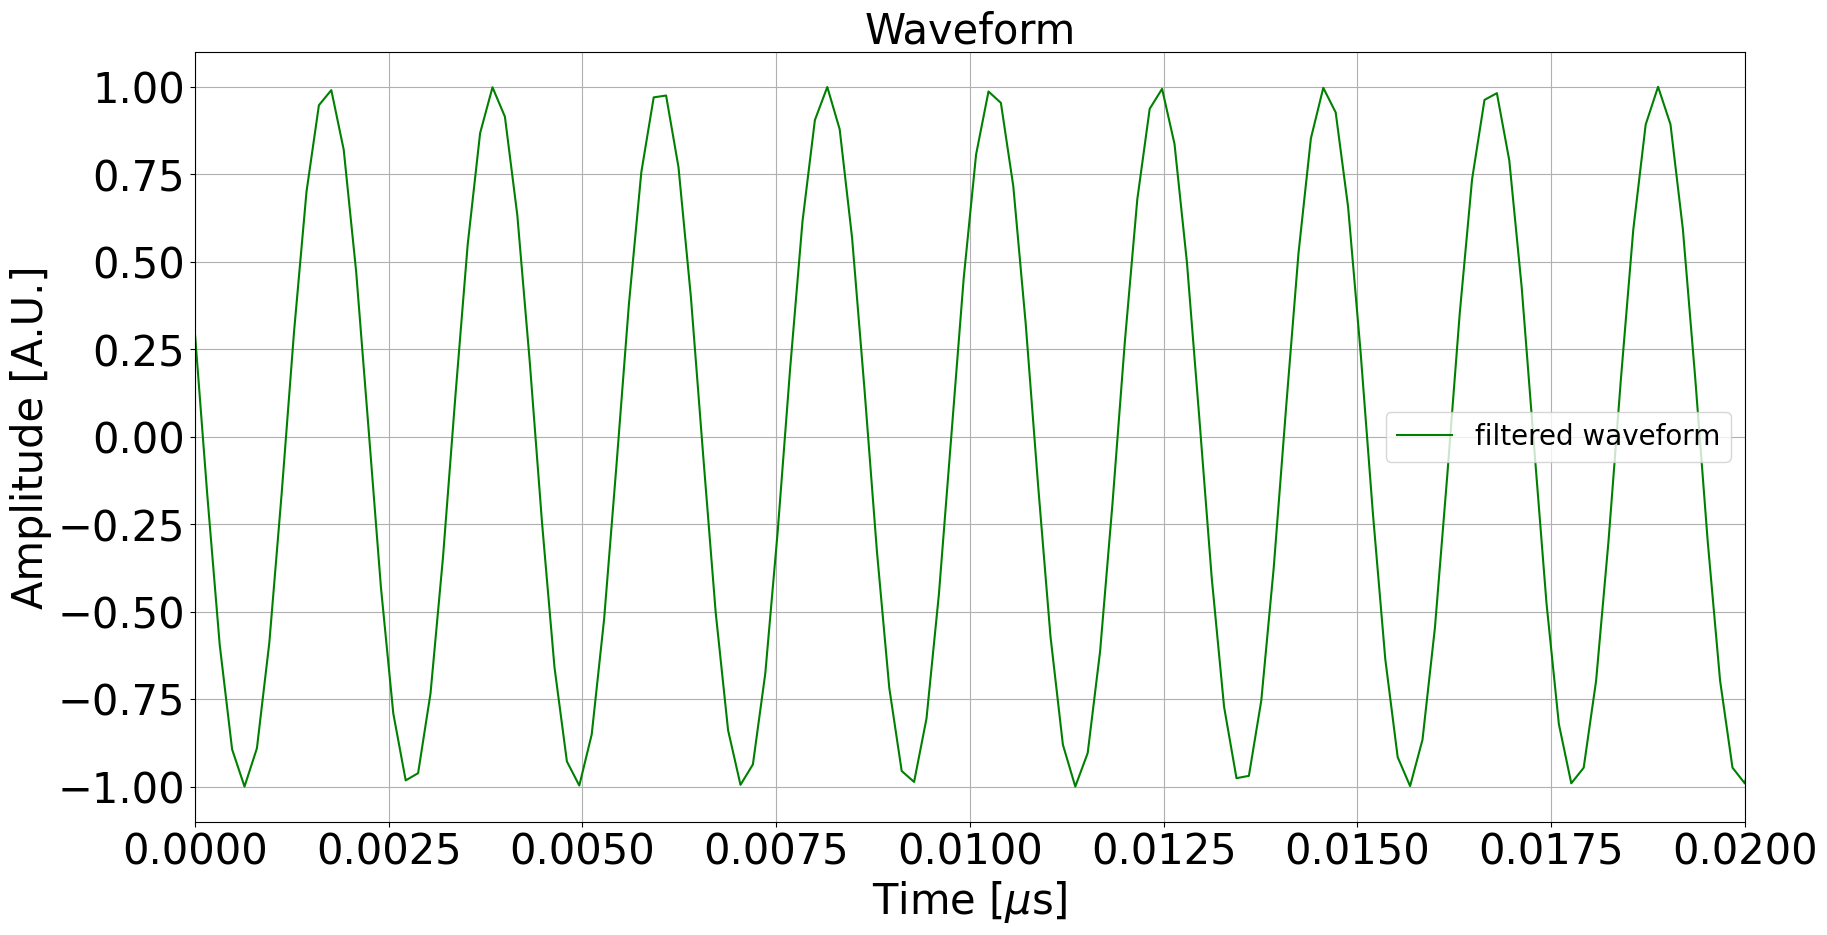

In [113]:
plt.figure(figsize = (20, 10))
print(len(original_wf))
print(len(noise_wf))
plt.plot(times_new_2, original_wf - noise_wf, label = 'filtered waveform', color = 'green')
plt.title('Waveform', fontsize = 30)
plt.xlabel(r'Time [$\mu$s]', fontsize = 30)
plt.xticks(fontsize = 30)
plt.ylabel('Amplitude [A.U.]', fontsize = 30)
plt.yticks(fontsize = 30)
plt.grid(True)
plt.xlim(0, 0.02)
plt.legend(loc = 'best', fontsize = 20)

#plt.savefig("Results/simple_ifft.png", format = "png", bbox_inches="tight")
#plt.savefig("Results/simple_ifft.pdf", format = "pdf", bbox_inches="tight")
plt.show()

In [114]:
#CHECK THIS WITH 2 SIMPLE WF